In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

if __name__ =='__main__':
    if not os.path.exists('./prepared_data/'):
        os.mkdir('./prepared_data/')
        
    df = pd.read_csv('./data/chessData.csv')
    
    train_df, test_df = train_test_split(df, test_size=0.2)

    train_df.to_csv('./prepared_data/train_chess_data.csv', encoding = 'utf-8', index=False)
    test_df.to_csv('./prepared_data/test_chess_data.csv', encoding = 'utf-8', index=False)
    


In [1]:
import pandas as pd 
import numpy as np
import chess
import torch


piece_list = ['pawn','knight','bishop','rook','queen','king']
piece_key = range(1,7)

piece_dict = dict(zip(piece_list, piece_key))

colour_dict = {'black':0, 'white':1}


def fen_translator(fen_string: str):
    
    board = chess.Board(fen_string)
    
    tensor = board_to_tensor(board = board)
    
    return tensor


def board_to_tensor(board: chess.Board) -> torch.Tensor:
    
    array_list = []
    
    for colour in colour_dict.values():
        for piece in piece_dict.values():
            piece_array = np.reshape(np.array(str(board.pieces(piece, colour)).replace(' ', ',').replace('.','0').replace('\n', ',').split(',')), (8,8)).astype(int)
            array_list.append(piece_array)
    
    
    array_list.append(create_ep_tensor(board))
    array_list.append(create_castle_tensor(board))
    array_list.append(create_half_move_clock_draw_tensor(board))
    array_list.append(create_to_move_tensor(board))
    
    tensor = torch.tensor(np.array(array_list))
    
    return tensor


def create_ep_tensor(board: chess.Board) -> np.ndarray:
    """
    Expects a board object and returns an 8x8 array with 1 on any ep position. 
    """
    
    
    ep_tensor = np.zeros(64)
    
    if board.ep_square:
        ep = board.ep_square
        ep_tensor[ep] = 1
        
    ep_tensor = ep_tensor.reshape(8,8)[-1::-1]
    
    return ep_tensor


def create_castle_tensor(board: chess.Board) -> np.ndarray:
    """
    Expects a board object and returns a 8x8 array with 1s in the corners where the kings may castle
    
    """
    
    castle_tensor = np.zeros(64).reshape((8,8))
    
    castling_rights = board.castling_rights
    
    pos_dict = {63: (0,7),
                56: (0,0),
                7: (7,7),
                0: (7,0)}
    
    for pos_number, pos_coordinates in pos_dict.items():
        
        if castling_rights >= 2**pos_number:
            castling_rights -= 2**pos_number
            castle_tensor[pos_coordinates] = 1
        
    return castle_tensor


def create_half_move_clock_draw_tensor(board: chess.Board) -> np.ndarray:
    
    if board.halfmove_clock>=100:
        
        return np.ones(64).reshape((8,8))
    
    else:
        
        return np.zeros(64).reshape((8,8))
    
    
def create_to_move_tensor(board: chess.Board) -> np.ndarray:
    
    if board.turn:
        return np.hstack((np.zeros(32), np.ones(32))).reshape(8,8)
    
    else:
        return np.hstack((np.ones(32), np.zeros(32))).reshape(8,8)
    
    
def evaluation_mate_handler(df: pd.DataFrame) -> pd.DataFrame:
    
    df = (df
          .dropna()
          .assign(Evaluation = lambda df: (df['Evaluation']
                                            .mask(df['Evaluation']
                                                  .str.contains('#-'), '-1000000')))
          .assign(Evaluation = lambda df: (df['Evaluation']
                                            .mask(df['Evaluation']
                                                  .str.contains('#+'), '1000000')))
          .assign(Evaluation = lambda df: (df['Evaluation']
                                           .str.replace('\ufeff', '')
                                           .str.replace(r'\s', '', regex=True)
                                           .str.replace('+', '')
                                           .astype(int))
                 )
         )
    
    return df



In [2]:
chess_path = './data/chessData.csv'

df = pd.read_csv(chess_path)


In [3]:
df = df.pipe(evaluation_mate_handler)

/tmp/ipykernel_14148/471159207.py:118: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('+', '')


<AxesSubplot:>

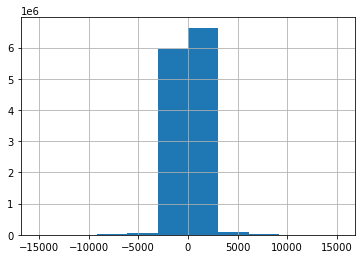

In [10]:
df.query('-1000000<Evaluation<1000000')['Evaluation'].hist()

<AxesSubplot:>

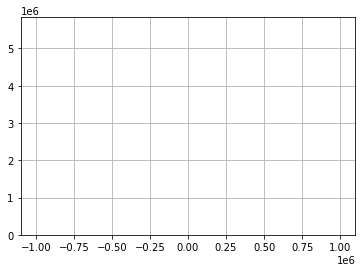

In [16]:
df['Evaluation'].hist(bins = 10000)

## Building the Pytorch Data Loader

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
class FENDataset(Dataset):

    def __init__(self, evaluation_file_path: str):
        self.evaluation_file_path = evaluation_file_path
        self.evaluation_data = (pd.read_csv(self.evaluation_file_path)
                                .pipe(evaluation_mate_handler))
        
        
    def __len__(self):
        return len(self.evaluation_data)
    
    def __getitem__(self, idx):
        label = self.evaluation_data.loc[idx, 'Evaluation']
        tensor = fen_translator(self.evaluation_data.loc[idx, 'FEN'])
        
        return tensor, label

In [20]:
train_dataset = FENDataset( './prepared_data/train_chess_data.csv')
test_dataset = FENDataset( './prepared_data/test_chess_data.csv')

/tmp/ipykernel_5308/471159207.py:118: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('+', '')
/tmp/ipykernel_5308/471159207.py:118: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('+', '')


In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [21]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 1., 0.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

In [1]:
import logging

In [2]:
fmtstr = "%(asctime)s: (%(filename)s): %(levelname)s: %(funcName)s Line: %(lineno)d - %(message)s"
datestr = "%Y-%m-%d %H:%M:%S"

In [3]:
logging.basicConfig(
        filename="custom_log_output.log",
        level=logging.DEBUG,
        filemode="w",
        format=fmtstr,
        datefmt=datestr,
  )

In [4]:
logging.info('this is a log')

In [4]:
print(f'{0.448298382392939283839283:.6f}')

0.448298


In [5]:
import numpy as np

In [7]:
a= np.array([2.546,3.489,7.4869,11.4698])
b= np.array([2.1546,3.4489,7.74869,11.54698])

np.sum((a-b)**2)

0.22929272649999977